# Supermarket-Sales Analysis

You can find the source here: https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales

Analysis of data obtained by the MySQL database, including data clustering and time series.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import warnings
import statsmodels.api as sm
from scipy.stats import jarque_bera
from sklearn.cluster import KMeans

In [2]:
# Disable warnings

warnings.filterwarnings('ignore')

In [3]:
# Connect to MySQL database

db_host = input('Host: ')
db_user = input('User: ')
db_password = input('Password: ')
db_database = input('Database: ')

def connect_db():
    return mysql.connector.connect(
        host=db_host,
        user=db_user,
        password=db_password,
        database=db_database
    )

connection = connect_db()
cursor = connection.cursor()

Host: localhost
User: root
Password: 123
Database: supermarket


In [4]:
# Data enrichment

total = 'price * quantity * 1.05' # Increases total sales by 5% (tax)
income = 'price * quantity * 0.05' # Gross income

In [5]:
# Dataframe

cursor.execute(f'''SELECT {total}, {income}, quantity, rating, datetime, Branch.city, Product.type,
                   Payment.name, Customer_type.name, Gender.name
                   FROM Sales
                   INNER JOIN Branch ON Sales.branch_id = Branch.id
                   INNER JOIN Product ON Sales.product_id = Product.id
                   INNER JOIN Payment ON Sales.payment_id = Payment.id
                   INNER JOIN Customer ON Sales.customer_id = Customer.id
                   INNER JOIN Customer_type ON Customer.customer_type_id = Customer_type.id
                   INNER JOIN Gender ON Customer.gender_id = Gender.id''')

df = pd.DataFrame(cursor.fetchall(), columns=['Total', 'Income', 'Quantity', 'Rating', 'Datetime', 'City',
                                              'Product', 'Payment', 'Customer', 'Gender'])

df['Total'] = df['Total'].astype(float)
df['Income'] = df['Income'].astype(float)
df['Rating'] = df['Rating'].astype(float)
df

,Total,Income,Quantity,Rating,Datetime,City,Product,Payment,Customer,Gender
0,246.4875,11.7375,5,7.1,2019-02-12 10:25:00,Yangon,Electronic accessories,Ewallet,Normal,Female
1,749.4900,35.6900,10,5.7,2019-03-29 19:21:00,Yangon,Health and beauty,Cash,Normal,Female
2,184.1070,8.7670,2,7.7,2019-03-10 12:17:00,Yangon,Fashion accessories,Credit card,Normal,Female
3,575.3160,27.3960,9,4.7,2019-01-15 17:17:00,Yangon,Electronic accessories,Ewallet,Normal,Female
4,115.0800,5.4800,10,6.0,2019-02-02 20:48:00,Yangon,Food and beverages,Ewallet,Normal,Female
...,...,...,...,...,...,...,...,...,...,...
995,477.1305,22.7205,9,5.4,2019-01-10 17:16:00,Naypyitaw,Food and beverages,Cash,Member,Male
996,96.5790,4.5990,1,9.8,2019-03-18 15:29:00,Naypyitaw,Fashion accessories,Cash,Member,Male
997,304.9830,14.5230,3,6.7,2019-03-30 20:37:00,Naypyitaw,Electronic accessories,Cash,Member,Male
998,250.2780,11.9180,4,9.8,2019-01-19 12:46:00,Naypyitaw,Food and beverages,Cash,Member,Male


In [6]:
# Close connection to database

cursor.close()
connection.close()

In [7]:
# Describe

df.describe()

,Total,Income,Quantity,Rating
count,1000.000000,1000.000000,1000.000000,1000.00000
mean,322.966749,15.379369,5.510000,6.97270
std,245.885335,11.708825,2.923431,1.71858
min,10.678500,0.508500,1.000000,4.00000
25%,124.422375,5.924875,3.000000,5.50000
50%,253.848000,12.088000,5.000000,7.00000
75%,471.350250,22.445250,8.000000,8.50000
max,1042.650000,49.650000,10.000000,10.00000


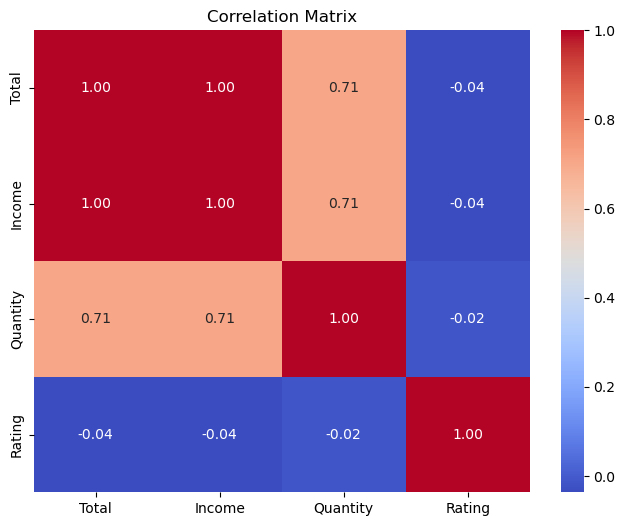

In [8]:
# Correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Rating seems to be the only variable that does not show correlation in relation to the others. It'll be used for clustering later.

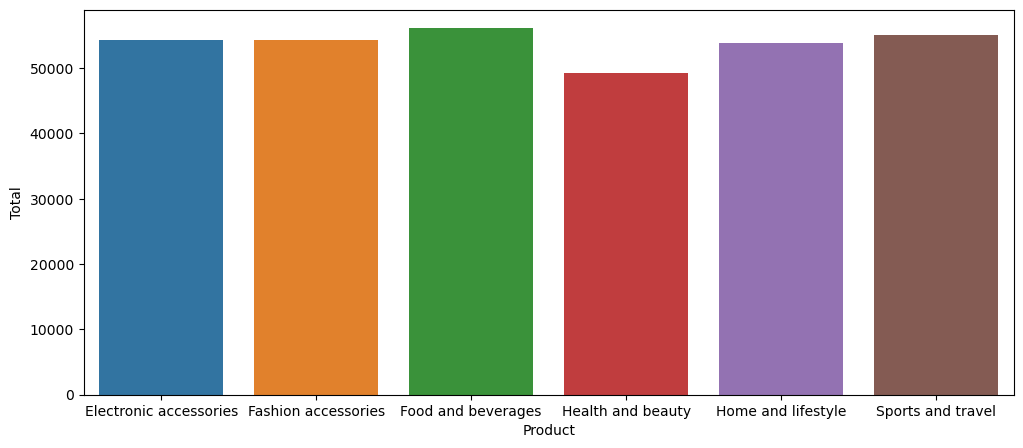

In [9]:
# Total price by product (barplot)

sales_product = df.groupby('Product', as_index=False)['Total'].sum()

plt.figure(figsize=(12, 5))
sns.barplot(data=sales_product, x='Product', y='Total')
plt.show()

The most sold type of product is Food and Beverages while the worst one is Health and Beauty.

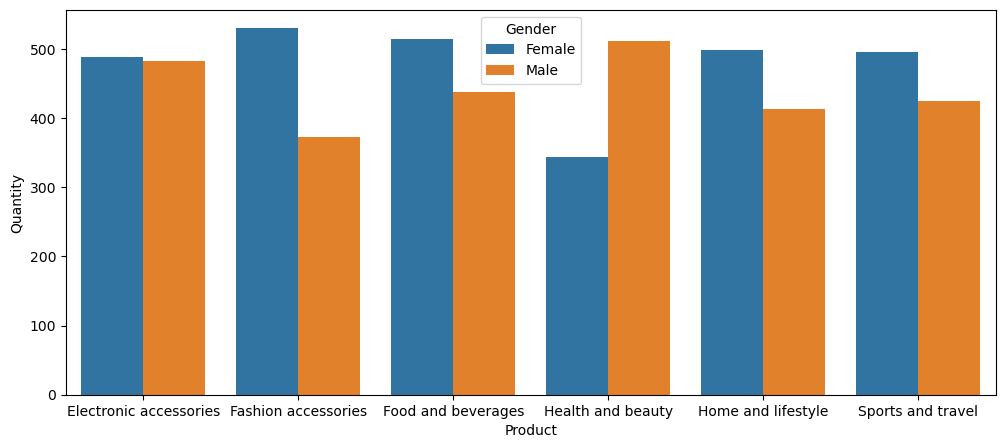

In [10]:
# Number of products sold by gender (barplot)

product_gender = df.groupby(['Gender', 'Product'], as_index=False)['Quantity'].sum()
product_gender

plt.figure(figsize=(12, 5))
sns.barplot(data=product_gender, x='Product', y='Quantity', hue='Gender')
plt.show()

It seems that females buy more products than males, with the exception of Health and Beauty. There is also a large discrepancy between males and females in Fashion Accessories.

In [11]:
# Number of products sold by gender

gender_quantity = df.groupby('Gender', as_index=False)['Quantity'].sum()
gender_quantity # 5510

,Gender,Quantity
0,Female,2869
1,Male,2641


Females represent around 52% of all products sold in markets compared to 48% from males.

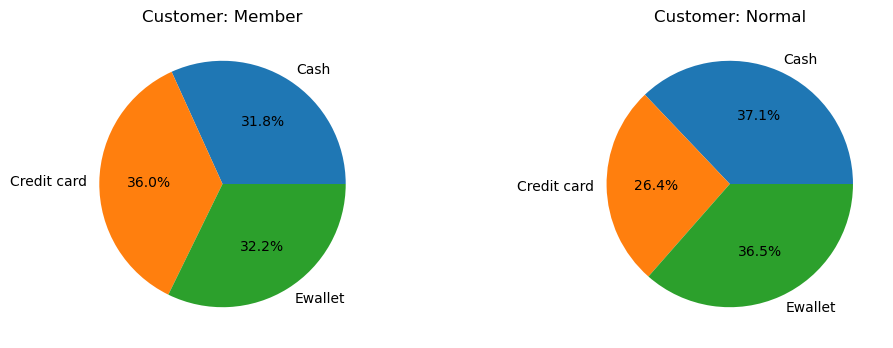

In [12]:
# Number of products sold by customer type and payment

customer_pay = df.groupby(['Customer', 'Payment'], as_index=False)['Quantity'].sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].pie(customer_pay[customer_pay['Customer'] == 'Member']['Quantity'],
            labels=customer_pay[customer_pay['Customer'] == 'Member']['Payment'], autopct='%1.1f%%')
axes[0].set_title('Customer: Member')

axes[1].pie(customer_pay[customer_pay['Customer'] == 'Normal']['Quantity'],
            labels=customer_pay[customer_pay['Customer'] == 'Normal']['Payment'], autopct='%1.1f%%')
axes[1].set_title('Customer: Normal')

plt.show()

The types of customers classified as members spend more with credit card than normal customers, which use cash and ewallet instead.

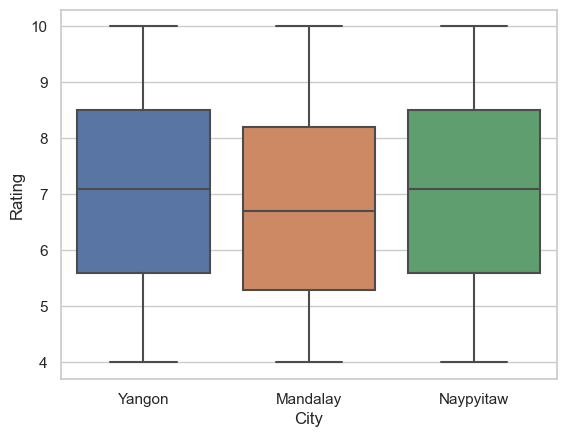

In [13]:
# Rating by branches (boxplot)

branch_rating = df.iloc[:, [3, 5]]

sns.set_theme(style="whitegrid")
sns.boxplot(data=branch_rating, x='City', y='Rating')
plt.show()

In [14]:
# Average rating by branch

branch_rating.groupby('City', as_index=False)['Rating'].mean()

,City,Rating
0,Mandalay,6.818072
1,Naypyitaw,7.072866
2,Yangon,7.027059


The sales rating in Madalay is inferior compared to other branches. Yangon and Naypyitaw rating are very similar.

### Grouping price total by sales evaluation (Clustering)

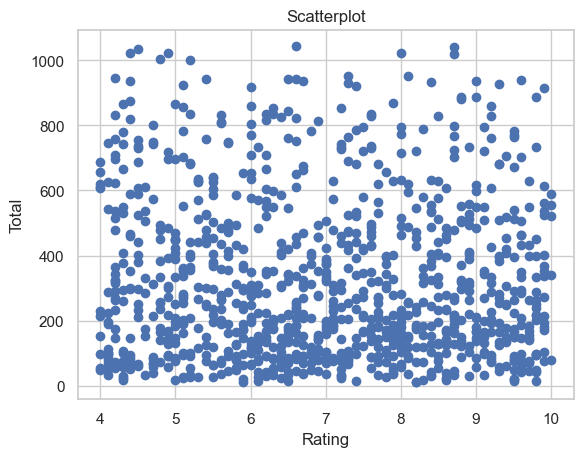

In [15]:
# Group total sale based on rating (clustering)

plt.scatter(x=df['Rating'].values, y=df['Total'].values)
plt.title('Scatterplot')
plt.xlabel('Rating')
plt.ylabel('Total')
plt.show()

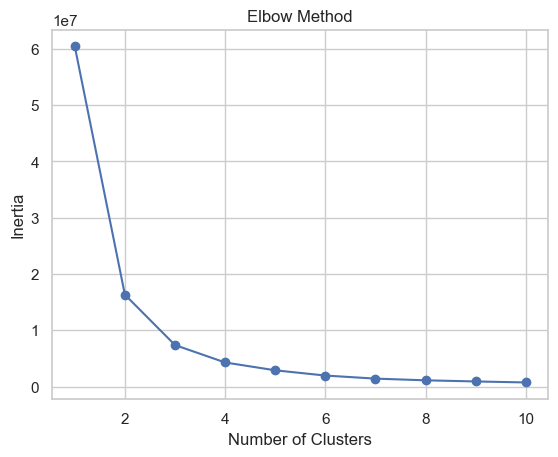

In [16]:
# Elbow Method

K = df[['Rating', 'Total']].values

inertia = []
for c in range(1,11):
    kmeans = KMeans(n_clusters=c, random_state=0)
    kmeans.fit(K)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(1,11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

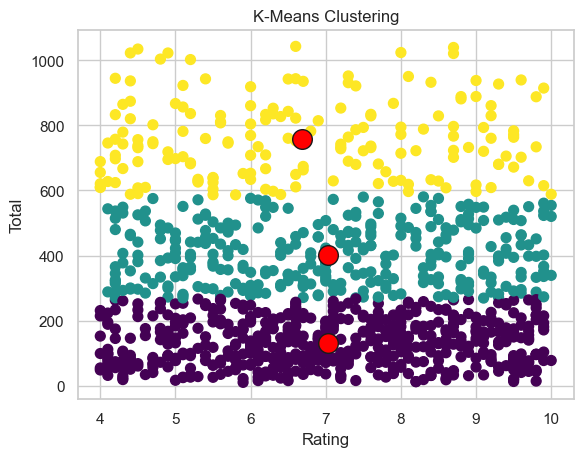

In [17]:
# K-Means Clustering

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(K)

labels = kmeans.predict(K)

centroids = kmeans.cluster_centers_

plt.scatter(x=K[:,0], y=K[:,1], c=labels, s=50, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,1], marker='o', s=200, color='red', edgecolor='k')
plt.title('K-Means Clustering')
plt.xlabel('Rating')
plt.ylabel('Total')
plt.show()

In [18]:
# Adding group values to dataframe

df['Group'] = labels
df['Group'].head()

0    0
1    2
2    0
3    1
4    0
Name: Group, dtype: int32

In [19]:
# Price range (0 - Low, 1 - Mid, 2 - High)

group_max = []

for i in range(3):
    interval = df[df['Group'] == i].groupby('Group')['Total'].max().values[0]
    group_max.append(interval)

print(f'''Group interval:
Total <= {group_max[0]}
{group_max[0]} < Total <= {group_max[1]}
Total > {group_max[1]}''')

Group interval:
Total <= 267.3405
267.3405 < Total <= 580.419
Total > 580.419


The total price is organized into three groups according to rating per sale.

### Time series analysis

The objective here is to analyze the trend in daily gross income per branch over time. For this purpose, time series are obtained per branch for data analysis.

In [20]:
# Prepare data

ts = df.iloc[:, [5, 4, 1]].copy()
ts.head()

,City,Datetime,Income
0,Yangon,2019-02-12 10:25:00,11.7375
1,Yangon,2019-03-29 19:21:00,35.6900
2,Yangon,2019-03-10 12:17:00,8.7670
3,Yangon,2019-01-15 17:17:00,27.3960
4,Yangon,2019-02-02 20:48:00,5.4800


In [21]:
# Convert datetime to date

ts['Datetime'] = pd.to_datetime(ts['Datetime']).dt.normalize()
ts = ts.rename(columns={'Datetime': 'Date'})
ts.head()

,City,Date,Income
0,Yangon,2019-02-12,11.7375
1,Yangon,2019-03-29,35.6900
2,Yangon,2019-03-10,8.7670
3,Yangon,2019-01-15,27.3960
4,Yangon,2019-02-02,5.4800


In [22]:
ts.nunique()

City        3
Date       89
Income    990
dtype: int64

Gross income can be organized into a series using cross section by setting a sliding window to avoid repetition of daily gains. After that, separate time series according to the city.

In [23]:
# Average sliding window

ts = ts.groupby(['City', 'Date'])['Income'].mean()
ts.head()

City      Date      
Mandalay  2019-01-01    24.392000
          2019-01-02    13.842875
          2019-01-03    16.138000
          2019-01-04     8.104500
          2019-01-05     7.726333
Name: Income, dtype: float64

In [24]:
# Temporal series by branch

ts_axs = ts.xs('Mandalay', level='City')
ts_bxs = ts.xs('Naypyitaw', level='City')
ts_cxs = ts.xs('Yangon', level='City')

ts_a = pd.DataFrame({'Date': ts_axs.index, 'Income': ts_axs.values}).set_index('Date').asfreq('D')
ts_b = pd.DataFrame({'Date': ts_bxs.index, 'Income': ts_bxs.values}).set_index('Date').asfreq('D')
ts_c = pd.DataFrame({'Date': ts_cxs.index, 'Income': ts_cxs.values}).set_index('Date').asfreq('D')

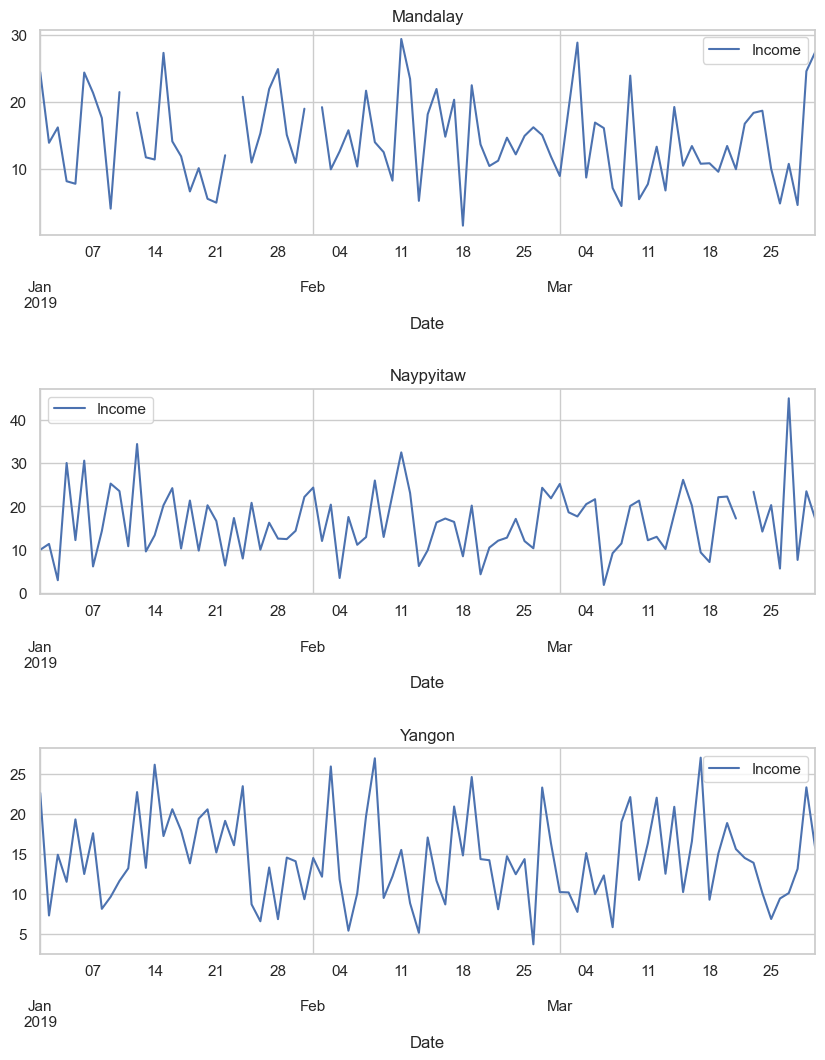

In [25]:
# Income graphic

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ts_a.plot(ax=ax1, title='Mandalay')
ts_b.plot(ax=ax2, title='Naypyitaw')
ts_c.plot(ax=ax3, title='Yangon')

plt.subplots_adjust(hspace=0.75)

plt.show()

In [26]:
# Check NAN values

print(f'''Check NAN values
Mandalay: {ts_a.isna().sum()}
Naypyitaw: {ts_b.isna().sum()}
Yangon: {ts_c.isna().sum()}''')

Check NAN values
Mandalay: Income    3
dtype: int64
Naypyitaw: Income    1
dtype: int64
Yangon: Income    0
dtype: int64


There are 3 missing data in Mandalay and 1 in Naypyitaw. One way to correct for missing data is to fill in the missing data with the mean.

In [27]:
# Fill in missing values with mean

ts_a = ts_a.fillna(ts_a.mean().iloc[0])
ts_b = ts_b.fillna(ts_b.mean().iloc[0])

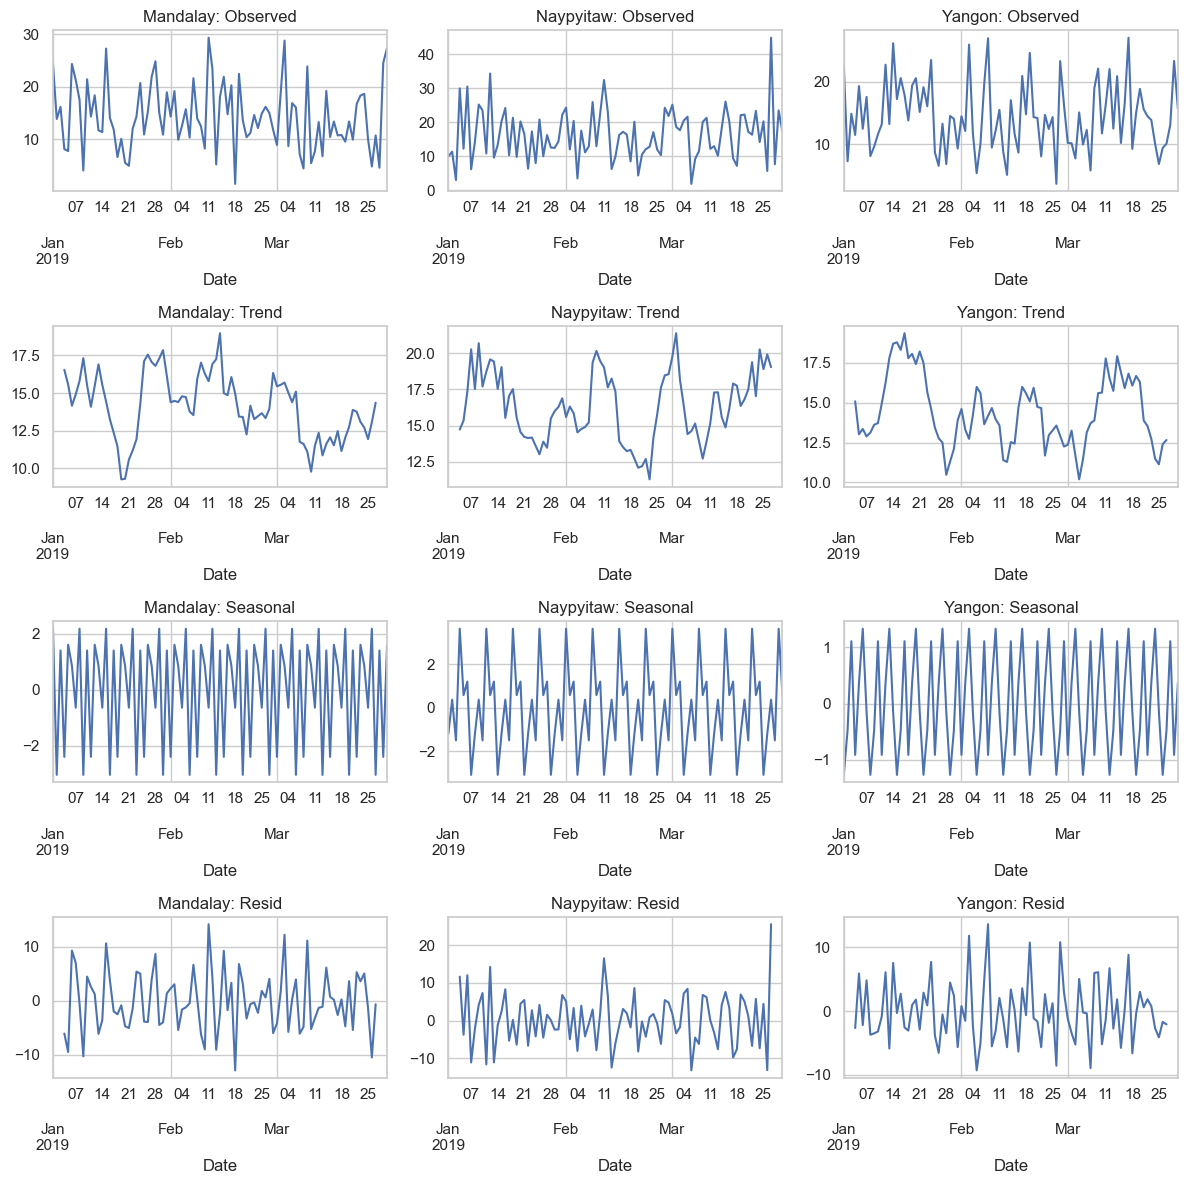

In [28]:
# Seasonal decompose

decomp_a = sm.tsa.seasonal_decompose(ts_a)
decomp_b = sm.tsa.seasonal_decompose(ts_b)
decomp_c = sm.tsa.seasonal_decompose(ts_c)

fig, axs = plt.subplots(4, 3, figsize=(12, 12))

decomp_a.observed.plot(ax=axs[0, 0], title='Mandalay: Observed')
decomp_b.observed.plot(ax=axs[0, 1], title='Naypyitaw: Observed')
decomp_c.observed.plot(ax=axs[0, 2], title='Yangon: Observed')

decomp_a.trend.plot(ax=axs[1, 0], title='Mandalay: Trend')
decomp_b.trend.plot(ax=axs[1, 1], title='Naypyitaw: Trend')
decomp_c.trend.plot(ax=axs[1, 2], title='Yangon: Trend')

decomp_a.seasonal.plot(ax=axs[2, 0], title='Mandalay: Seasonal')
decomp_b.seasonal.plot(ax=axs[2, 1], title='Naypyitaw: Seasonal')
decomp_c.seasonal.plot(ax=axs[2, 2], title='Yangon: Seasonal')

decomp_a.resid.plot(ax=axs[3, 0], title='Mandalay: Resid')
decomp_b.resid.plot(ax=axs[3, 1], title='Naypyitaw: Resid')
decomp_c.resid.plot(ax=axs[3, 2], title='Yangon: Resid')

plt.tight_layout()
plt.show()

There is evidence of weekly periodicity in all time series based on seasonal decomposition.

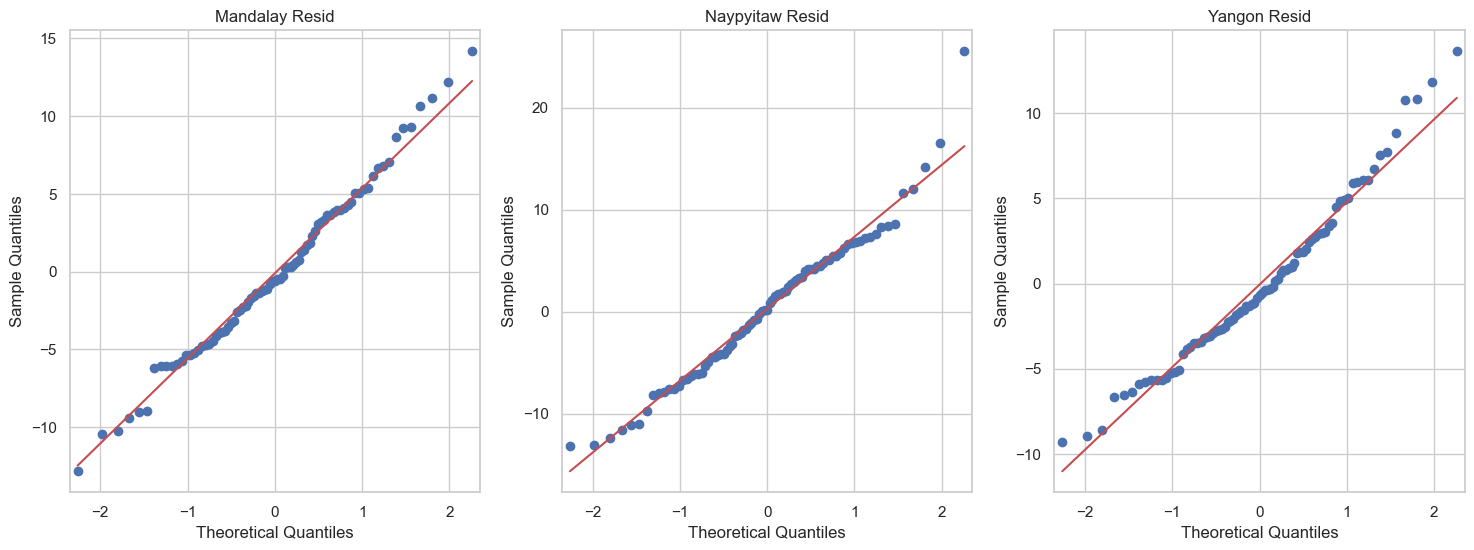

In [29]:
# Normal distribution check

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sm.qqplot(sm.tsa.seasonal_decompose(ts_a).resid.dropna(), line='s', ax=axes[0])
sm.qqplot(sm.tsa.seasonal_decompose(ts_b).resid.dropna(), line='s', ax=axes[1])
sm.qqplot(sm.tsa.seasonal_decompose(ts_c).resid.dropna(), line='s', ax=axes[2])

axes[0].set_title('Mandalay Resid')
axes[1].set_title('Naypyitaw Resid')
axes[2].set_title('Yangon Resid')

plt.show()

In [30]:
# Jarque-Bera test

jb_stat_a, jb_p_a = jarque_bera(sm.tsa.seasonal_decompose(ts_a).resid.dropna())
jb_stat_b, jb_p_b = jarque_bera(sm.tsa.seasonal_decompose(ts_b).resid.dropna())
jb_stat_c, jb_p_c = jarque_bera(sm.tsa.seasonal_decompose(ts_c).resid.dropna())

print(f'''Jarque-Bera results

Mandalay Resid
JB statistic: {jb_stat_a}
p-value: {jb_p_a}

Naypyitaw Resid
JB statistic: {jb_stat_b}
p-value: {jb_p_b}

Yangon Resid
JB statistic: {jb_stat_c}
p-value: {jb_p_c}''')

Jarque-Bera results

Mandalay Resid
JB statistic: 0.9231033034031755
p-value: 0.6303048727177987

Naypyitaw Resid
JB statistic: 4.940851442776759
p-value: 0.08454885708189208

Yangon Resid
JB statistic: 4.53930106008995
p-value: 0.10334829089548181


All time series residuals follow a normal distribution based on the 5% significance level.

In [31]:
# Linear regression

X_a, y_a = sm.add_constant(np.array(range(len(ts_a)))), ts_a.values
X_b, y_b = sm.add_constant(np.array(range(len(ts_b)))), ts_b.values
X_c, y_c = sm.add_constant(np.array(range(len(ts_c)))), ts_c.values

reg_a = sm.OLS(y_a, X_a).fit()
reg_b = sm.OLS(y_b, X_b).fit()
reg_c = sm.OLS(y_c, X_c).fit()

print(f'''Coefficients

Mandalay
Intercept: {reg_a.params[0]}
Angular: {reg_a.params[1]}

Naypyitaw
Intercept: {reg_b.params[0]}
Angular: {reg_b.params[1]}

Yangon
Intercept: {reg_c.params[0]}
Angular: {reg_c.params[1]}''')

Coefficients

Mandalay
Intercept: 15.368505318932721
Angular: -0.024195750666874436

Naypyitaw
Intercept: 15.524921979100792
Angular: 0.018422399924017632

Yangon
Intercept: 15.072812088014974
Angular: -0.013572793910209685


It's observed that there is little indication of growth in gross income in the city of Naypyitaw. In other cases, there is a reduction in gain over time. These results serve as a warning for possible decision-making to correct the reduction in earnings in cities.